# Medical Appointment No-Shows Analysis


## Introduction

In this notebook we will explore a dataset containing aproximately 100k medical appointments from the Brazilian public health system. One of the largest health system of the world.

> This is at municipal level combining the appointments occured in more then 45 units. As fasr as we know, the city has 20 million loss a year with no-shows. After so many studies happening in this data the average no-show now is 20\%. It is important to mention that all services offered to the municipality were free of charge.

This analysis is focused on the question of whether or not patients show up for their appointment, including a set of characterisitics about the patient in each row:

* `ScheduledDay`: tells us on which day the patient set up their appointment.
* `Neighborhood`: indicates the location of the hopital.
* `Scholarhip`: indicates whether or not the patient is enrolled in Brasilian welfare program called *Bolsa familia*
* `No-show`: it says `No` if the patient showed up to their appointment, and `Yes` if they didn't show up.

This analysis aims to outline some possible reasons for patient no-showing at the scheduled appointments, as well as get insights about the Brazilian public health system.

### Initial Statements

This section sets up import statements for all packages that will be used throught this python notebook.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import warnings

In [2]:
# set notebook environment
%matplotlib inline

sns.set_style('white')

%precision %.3f
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = 10,8

pd.set_option('display.width', 100, 'display.max_rows', 81)

plt.rcParams.update({'font.size': 22})
# Few tweaked Pandas options for friendlier output:

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

warnings.filterwarnings('ignore')
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [3]:
df = pd.read_csv('../Datasets/KaggleV2-May-2016.csv.zip')

## Getting to Know Your Data

In [4]:
df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99241,"79,831,615,436,492.00",5755796,F,2016-06-01T07:41:29Z,2016-06-01T00:00:00Z,53,CENTRO,0,1,0,1,0,0,No
42758,"6,827,155,863,116.00",5651059,M,2016-05-03T08:22:45Z,2016-05-10T00:00:00Z,2,SANTA MARTHA,0,0,0,0,0,1,Yes
28461,"734,821,274,881,758.00",5612166,M,2016-04-25T07:59:41Z,2016-05-04T00:00:00Z,4,ROMÃO,0,0,0,0,0,1,Yes
5224,"475,956,964,989.00",5709510,M,2016-05-17T13:52:43Z,2016-05-24T00:00:00Z,53,BENTO FERREIRA,0,0,1,0,1,1,No
41190,"1,287,554,816,336.00",5663494,F,2016-05-05T10:08:01Z,2016-05-25T00:00:00Z,19,MARIA ORTIZ,0,0,0,0,0,1,No


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 44.3 MB


In [6]:
print ("Rows     : " , df.shape[0])
print ("\nUnique values :  \n",df.nunique())

Rows     :  110527

Unique values :  
 PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64


In [7]:
for col in df.columns:
    if df[col].nunique() < 100:
        print(f'Unique values in {col}: {df[col].unique()} \n')

Unique values in Gender: ['F' 'M'] 

Unique values in AppointmentDay: ['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00:00Z' '2016-05-18T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z' '2016-06-06T00:00:00Z'
 '2016-06-07T00:00:00Z' '2016-06-01T00:00:00Z' '2016-06-08T00:00:00Z'] 

Unique values in Neighbourhood: ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIE

### Descriptive Statistics


In [8]:
df.describe().iloc[:,2:]

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,"110,527.00","110,527.00","110,527.00","110,527.00","110,527.00","110,527.00","110,527.00"
mean,37.09,0.10,0.20,0.07,0.03,0.02,0.32
std,23.11,0.30,0.40,0.26,0.17,0.16,0.47
min,-1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,37.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,55.00,0.00,0.00,0.00,0.00,0.00,1.00
max,115.00,1.00,1.00,1.00,1.00,4.00,1.00


In [9]:
df.describe(include='object',)

,Gender,ScheduledDay,AppointmentDay,Neighbourhood,No-show
count,110527,110527,110527,110527,110527
unique,2,103549,27,81,2
top,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,JARDIM CAMBURI,No
freq,71840,24,4692,7717,88208


## Data Wrangling

### Update Data Types
Let's clean our dataset a bit.
We start by transforming the data the right format. It allows us to save some memory and simplifies further processing.

In [10]:
# Update neighborhood, Gender and No-show data types
# From object to category
df['Neighbourhood'] = df['Neighbourhood'].astype('category')
df['Gender'] = df['Gender'].astype('category')

# Convert Paient ID data type from float to int
df['PatientId'] = df['PatientId'].astype(int)

# Replace Yes/No with True/False
df['No-show'].replace({'No': False, 'Yes': True}, inplace=True)

In [11]:
df[['ScheduledDay']].head(3)

,ScheduledDay
0,2016-04-29T18:38:08Z
1,2016-04-29T16:08:27Z
2,2016-04-29T16:19:04Z


While the scheduling date is recorded to the second, the time of the appointment is missing. Schade!
I would like to add two more columns to the dataset: number of waiting days as well as the appointment as day of the week. But before let's change the data type of the scheduling day and remove the time from it.

In [12]:
# From object to datetime
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'].str.split('T').str[0])
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'].str.split('T').str[0])

### Add, Remove and Update  Features

Now that we have converted the dates to the correct data type format: `Timestamps` , we can compute the waiting days till appointment by a simple substraction:

In [13]:
df['WaitingDays'] = df['AppointmentDay'] - df['ScheduledDay']

# Transform the waiting days to int
df['WaitingDays'] = df['WaitingDays'].dt.days

Remove appointment IDs, they don't contain any valuable information. We could also remove patient ID's, however I want to check if some patients didn't show more than twice. We will also remove the 'ScheduledDay' variable

In [14]:
# remove  'AppointmentID' & 'ScheduledDay'
df.drop(['AppointmentID'], axis=1, inplace=True);

In [15]:
# Rename columns
df.rename(columns={'Neighbourhood': 'Neighborhood',
                   'Handcap': 'Handicap',
                   'Hipertension': 'Hypertension',
                   'AppointmentDay': 'AppointmentDate'},
          inplace=True)

In [16]:
 df['AppointmentDate'].dt.day_name().astype('category').unique()

['Friday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday', 'Saturday']
Categories (6, object): ['Friday', 'Tuesday', 'Monday', 'Wednesday', 'Thursday', 'Saturday']

In [17]:
# change upper case to title case inside Neighborhood
df['Neighborhood'] = df['Neighborhood'].str.title().astype('category')
df['Neighborhood'][0]

'Jardim Da Penha'

In [18]:
# Extract Day of the week and Month from appointments
df['AppointmentMonth'] = df['AppointmentDate'].dt.month_name().astype('category')
df['AppointmentDay'] = df['AppointmentDate'].dt.day_name().astype('category')

### Data Consistency Check

In [19]:
# Let's check the consistency of the results
df[df['WaitingDays'] < 0]

,PatientId,Gender,ScheduledDay,AppointmentDate,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,WaitingDays,AppointmentMonth,AppointmentDay
27033,7839272661752,M,2016-05-10,2016-05-09,38,Resistência,0,0,0,0,1,0,True,-1,May,Monday
55226,7896293967868,F,2016-05-18,2016-05-17,19,Santo Antônio,0,0,0,0,1,0,True,-1,May,Tuesday
64175,24252258389979,F,2016-05-05,2016-05-04,22,Consolação,0,0,0,0,0,0,True,-1,May,Wednesday
71533,998231581612122,F,2016-05-11,2016-05-05,81,Santo Antônio,0,0,0,0,0,0,True,-6,May,Thursday
72362,3787481966821,M,2016-05-04,2016-05-03,7,Tabuazeiro,0,0,0,0,0,0,True,-1,May,Tuesday


In [20]:
# remove negative waiting days
df = df[df['WaitingDays'] >= 0]

Check age consistency

In [21]:
len(df[df['Age'] < 0])

1

In [22]:
# Remove non consistent ages
df = df[df['Age'] >= 0]
df.reindex();

### Memory Optimization

In [23]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   PatientId         110521 non-null  int64         
 1   Gender            110521 non-null  category      
 2   ScheduledDay      110521 non-null  datetime64[ns]
 3   AppointmentDate   110521 non-null  datetime64[ns]
 4   Age               110521 non-null  int64         
 5   Neighborhood      110521 non-null  category      
 6   Scholarship       110521 non-null  int64         
 7   Hypertension      110521 non-null  int64         
 8   Diabetes          110521 non-null  int64         
 9   Alcoholism        110521 non-null  int64         
 10  Handicap          110521 non-null  int64         
 11  SMS_received      110521 non-null  int64         
 12  No-show           110521 non-null  bool          
 13  WaitingDays       110521 non-null  int64         
 14  Appo

As we can see, just by updating the variables data types we drastically reduced the memory usage; from 44 MB to 9 MB. We could much better: many features can be converted to boolean and age and waiting days to int8. It depends on the available RAM and the size of the dataset, for me 9 MB are fine.

## Exploratory Data Analysis

Once the data has been cleaned and trimmed, we can move on to explore it. I, usually start by looking at each variable independently and try to find interesting behaviour to further investigate. Thus, the most interesting hypotheses to explore are posed at this stage of the analysis.

### Neighborhood Analysis

We will explore the no-showing appointments relative to neighborhoods. We start by plotting the distribution of appointments per neighborhood.

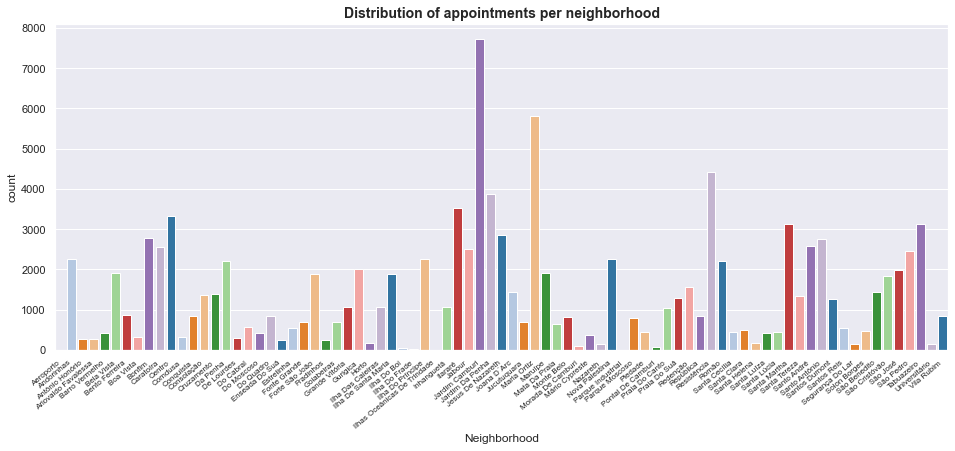

In [24]:
col_pal = sns.color_palette("tab20", n_colors=10)
sns.set(style='darkgrid', context='notebook', rc={"figure.figsize": (16, 6)})
g = sns.countplot(data=df, x='Neighborhood', palette=col_pal)
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of appointments per neighborhood', fontsize=14, fontweight='bold');

Some of the neighborhoods have substantially less appointments than others. So, it's interesting to further investigate this matter. Let's first start by plotting the No-showing rate by neighborhood.

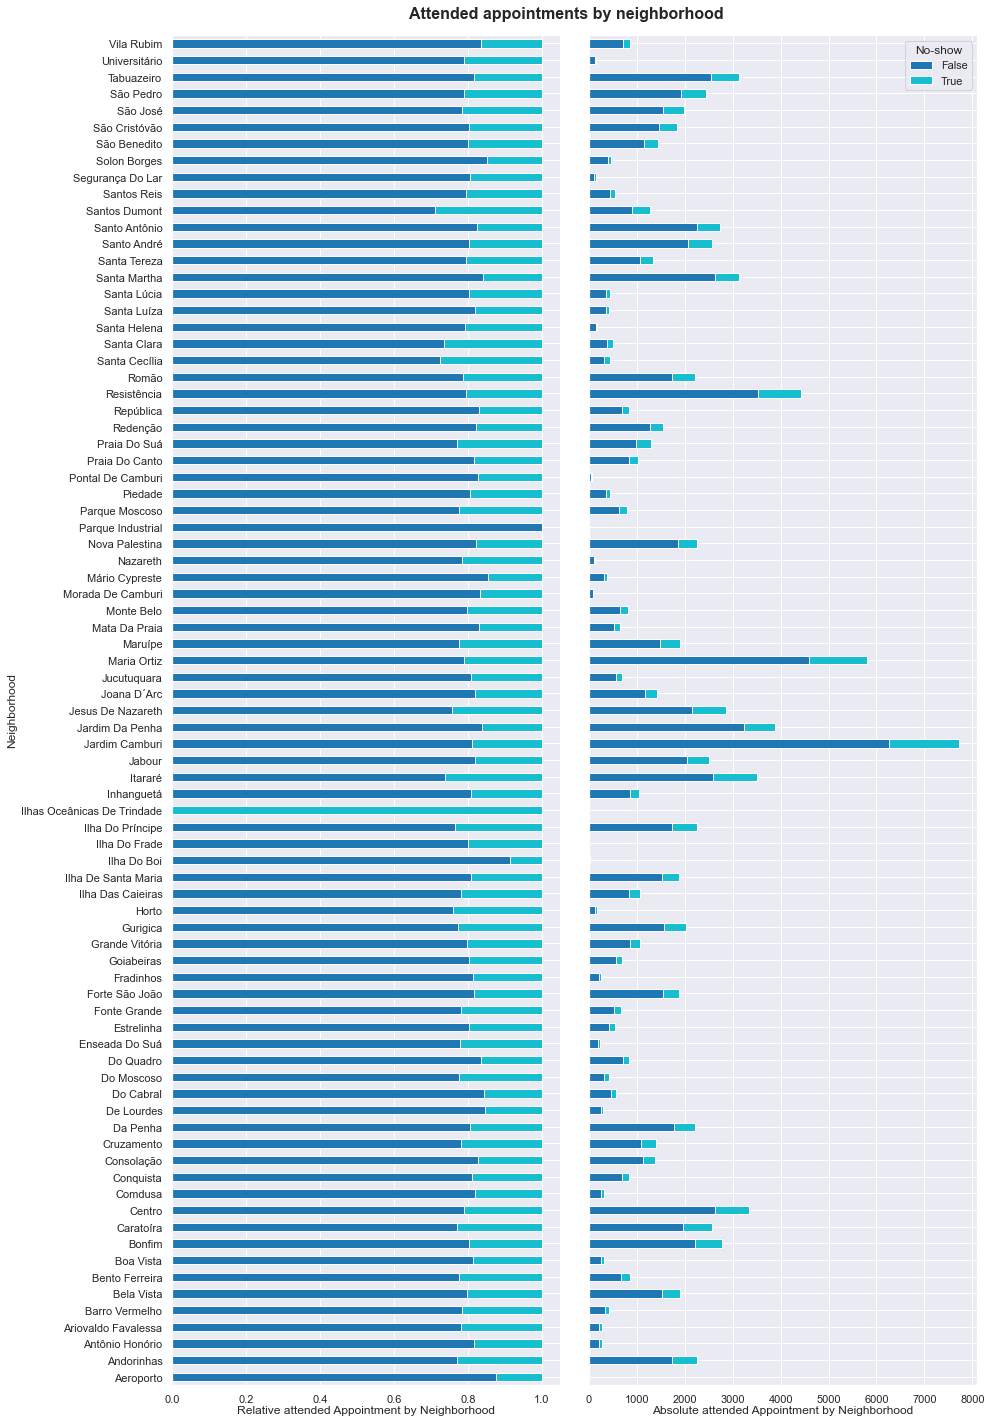

In [25]:
## Initialize the matplotlib figure:
fig, axs = plt.subplots(1,2, figsize=(12, 20), sharey=True)
fig.tight_layout() 
fig.subplots_adjust(top=.96)  #Adjusting the space for the superior title

pd.crosstab(df['Neighborhood'], 
            df['No-show'], normalize='index').plot.barh(align='center', 
                                                        cmap='tab10',
                                                        stacked=True, ax=axs[0])
axs[0].get_legend().remove()
axs[0].set_title('Relative attended Appointment by Neighborhood', fontsize=12, y=-.025)

pd.crosstab(df['Neighborhood'], df['No-show']).plot.barh(align='center', stacked=True, 
                                                         cmap='tab10',ax=axs[1])

axs[1].set_title('Absolute attended Appointment by Neighborhood', fontsize=12, y=-.025)

plt.suptitle('Attended appointments by neighborhood', fontsize=16, fontweight='bold');

From this plot we see 2 extreme cases. One with 100% No-show rate and other with 0% No-show rate. However, they are statistically irrelevant, since they represent one appointment each.

<div class="alert alert-block alert-warning">
<b>1st Hypothesis:</b> <br> 
   Number of appointments per Neighborhood doesn't affect the No-show probability.
</div>

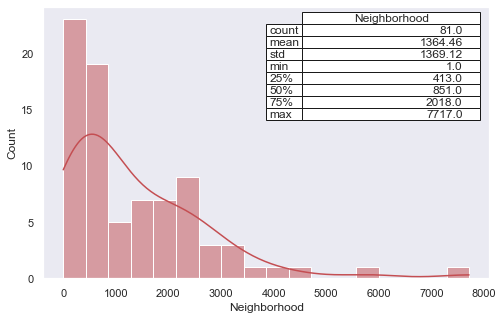

In [26]:
# 5 number summary of the number of appointments
sns.set(style='dark', rc={"figure.figsize": (8, 5)})
g=sns.histplot(x=df['Neighborhood'].value_counts(), color='r', bins=18, kde=True)# width=.2);
pd.plotting.table(g, np.round(df['Neighborhood'].value_counts().describe(), 2), 
                  loc='upper right', colWidths=[.4, 1]);

As we can see form above, there is a big a descripancy between the total number of appointments per health unit. 
Most of them

In [27]:
#  
arr = df['Neighborhood'].value_counts()
intervals = pd.cut(arr[::-1].cumsum(), np.linspace(arr.min(), arr.sum(), 10+1), include_lowest=True).cat.codes
df['NeighbourGroups'] = df['Neighborhood'].replace(dict(intervals))
group_app_dist = df.groupby(df['NeighbourGroups'])['Neighborhood'].count()

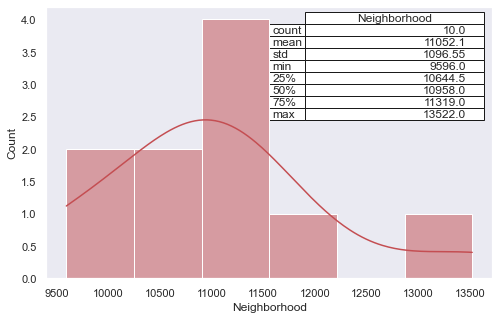

In [28]:
g=sns.histplot(x=group_app_dist, color='r', bins=6, kde=True)# width=.2);
pd.plotting.table(g, np.round(group_app_dist.describe(), 2), 
                  loc='upper right', colWidths=[.4, 1]);

In [29]:
group_app_dist.sort_values(ascending=True, inplace=True)

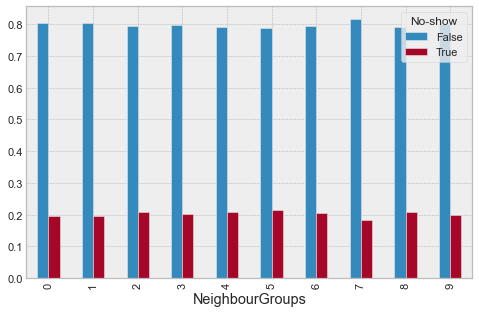

In [30]:
plt.style.use('bmh')
df.groupby('NeighbourGroups')['No-show'].value_counts(normalize=True).unstack().plot.bar();

In [31]:
df.groupby('NeighbourGroups')['No-show'].value_counts(normalize=True).unstack()

No-show,False,True
NeighbourGroups,,
0,0.80,0.20
1,0.81,0.19
2,0.79,0.21
3,0.80,0.20
4,0.79,0.21
5,0.79,0.21
6,0.80,0.20
7,0.82,0.18
8,0.79,0.21


It is now clear that there is no correlation between patients showing to an appointment and number of appointment per neighborhood. 
Thus, the first hypothesis is true. 

### Waiting Days Analysis

<div class="alert alert-block alert-warning">
<b>2nd Hypothesis:</b> <br>
    There is no correlation between total number of appointments per Neighborhood and waiting days till appointment.
</div>

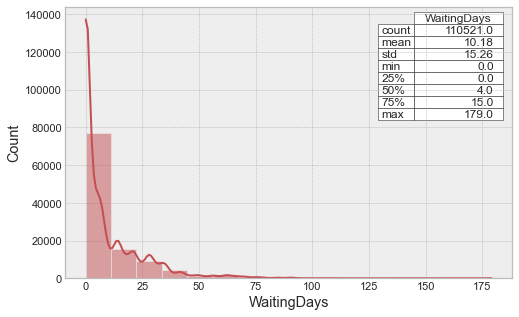

In [32]:
g = sns.histplot(data=df, x='WaitingDays',kde=True, color='r', bins=16)
pd.plotting.table(g, np.round(df['WaitingDays'].describe(), 2), 
                  loc='upper right', colWidths=[.2, .2, .3, .3]);

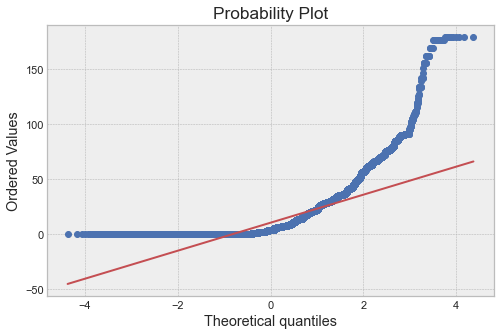

In [33]:
import scipy.stats as stats

stats.probplot(df['WaitingDays'], dist='norm', plot=plt);

The average waiting is about 10 days, with a standard deviation of approximately 15 days and maximum of 179 days. The qqplot suggests that the data right skewed with a long tail.

The days that a patient has to wait for a consultation varies from 0 to 175 days. For a better overview and analysis we will group the WaitingsDays into categories or bins.

In [34]:
categories = pd.Series(['same day', '1-3', '4-7', '8-15', 
                        '16-30', 'over 30days'])
df['WaitingPeriods'] = pd.cut(df['WaitingDays'], bins=[-1, 0, 3, 7, 15, 30, 90], labels=categories)

In [35]:
waitsperGroups = pd.crosstab(df['WaitingPeriods'], df['NeighbourGroups'] )
# Sort waitperGroups using total number of appointments in an ascending way
waitsperGroups = waitsperGroups.loc[:, group_app_dist.sort_values(ascending=True).index]

Now we want to see if the long waits are somehow correlated with the total number of appointments per health unit. This could indicate a shortage of doctors or nurses in certain regions.

In [36]:
longwaits = pd.concat([group_app_dist, waitsperGroups.iloc[-1:, :].T], axis=1)


In [37]:
longwaits = longwaits[['over 30days', 'Neighborhood']]
longwaits.rename(columns={'Neighborhood': 'Appointments'}, inplace=True)

In [38]:
longwaits

,over 30days,Appointments
NeighbourGroups,,
7,764,9596
5,522,9788
0,826,10592
1,591,10802
6,641,10941
4,469,10975
2,978,11088
3,968,11396
8,1078,11821


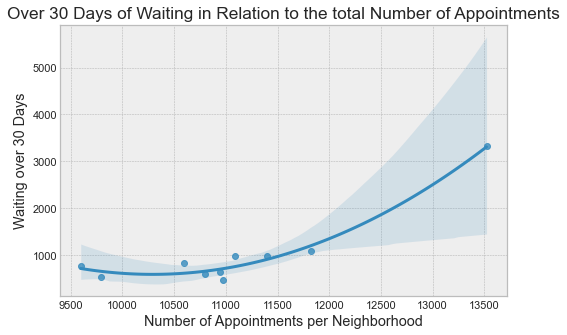

In [39]:
sns.regplot(data=longwaits, x='Appointments', y='over 30days', order=2);
plt.ylabel('Waiting over 30 Days')
plt.xlabel('Number of Appointments per Neighborhood')
plt.title('Over 30 Days of Waiting in Relation to the total Number of Appointments');

There is obviously a non linear relationship between the number of appointments per Neighborhood and long waiting times. The more appointments there are, the longer is the waiting time. Long waiting times in Jardim Camburi and Maria Ortiz represent 25% of the appointment. Which is huge. 
Thus the second hypothesis is not true.

Now I want to check the relationship between the no-showing rate and waiting days.
We start by stating our null-hypothesis.

<div class="alert alert-block alert-warning">
<b>
    3rd Hypothesis:</b> <br>
    Number of waiting days doesn't affect the No-show rate.
</div>

In [40]:
df.groupby('WaitingPeriods')['No-show'].mean()

WaitingPeriods
same day      0.05
1-3           0.23
4-7           0.25
8-15          0.31
16-30         0.33
over 30days   0.33
Name: No-show, dtype: float64

There is a strong correlation between waiting time and no-show rate. Thus the 3rd Nullhypothesis is wrong.
In addition I suggest to no longer include the same day appointments into the analysis. Since the no-show rate is around 5% and what do you want more, you can't improve it, and even if you do, how much is it going to be and is it worth the investment. 
The same day appointments also distort the overall statistics and cover up a much worse situation (a bit eggagerated).
I guess because, they are not really appointments, but urgent cases or spontaneous patient visits (?!).

-------

One last hypothesis emerges from the above observations: What if patients with long waiting times just decide to go sponteneously to the doctor, without notice or canceling their frist scheduled appointment. 
One way in checking that is by analysing patients ID's with more than one appointment.

<div class="alert alert-block alert-warning">
<b>4th Hypothesis:</b> <br> 
    Patients with long waiting times don't try to get sooner appointments or go to the doctor without notice. 
</div>

In [41]:
# List of patients with multiple appointments
multi_apps = df[df['PatientId'].duplicated(keep=False)].sort_values(by='PatientId').copy()

In [42]:
print(f"Number of Patients with multiple appointments {multi_apps['PatientId'].nunique()}")
print(f"Number of Appointments {len(multi_apps['PatientId'])}")

Number of Patients with multiple appointments 24378
Number of Appointments 72601


It is a long list, worth an in-depth analysis. 

In [43]:
# We are interested in Patients with at least one no-show
mask = (multi_apps.groupby('PatientId')['No-show'].mean() > 0 )
multi_apps = multi_apps[multi_apps['PatientId'].isin(mask[mask.values].index)].sort_values(by='PatientId')

It is a long list, worth an in-depth analysis. However, it seems to me that the 4th hypothesis won't be easy to check, due to the lack of key information, such as: is it an appointment by the same kind of doctor and for the same matter? Or is it an appointment for a different matter? 

--------

So let's continue with were we left before this 4th hypothesis and remove the same day appointments from our dataset. 

In [44]:
tmp = df.copy()
df = df[df['WaitingDays'] > 0]

In [45]:
# remove the same category
df['WaitingPeriods'].cat.remove_unused_categories(inplace=True);

In [46]:
df['No-show'].value_counts(normalize=True)

False   0.71
True    0.29
Name: No-show, dtype: float64

The overall no-show rate is now around 30% and not 20% as stated above. What we should do now, is to repeat all the analysis from above without the same days appointments. Due to lack of time, I won't be able to do it. However, from now on I only consider the new generated dataframe.

### Factor Age

<div class="alert alert-block alert-warning">
<b>5th Hypothesis:</b> <br>
    No-showing rate is not is not affected by the age group.
</div>

We will differentiate between 2 main group of patients: the under 16 and over 16. Since the former don't enjoy a doctor-patient confidentiality yet and usually they must bring one of their parent for a consultation, including them in the overall probability analysis doesn't make really sense... to me. They usually don't show because of their parents and not because of a handicap or something else.
However let's compare the no-show rates between those two groups.

In [47]:
print('children patients')
df[df['Age']<16]['No-show'].value_counts(normalize=True)

children patients


False   0.68
True    0.32
Name: No-show, dtype: float64

In [48]:
df[df['Age']>15]['No-show'].value_counts(normalize=True)

False   0.72
True    0.28
Name: No-show, dtype: float64

That the no-show rate by infants and children until 15 years old, is larger than average, was to be expected.  Even if I don't have the right explanation for that. Clearly something need to be done here. Like a second call one or two days before the appointment to confirm the attendance or it is automatically canceled. 

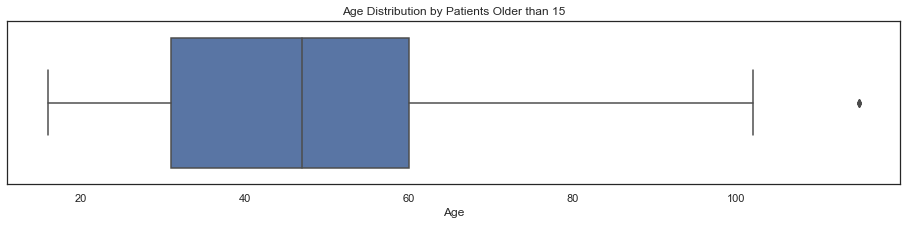

In [49]:
# Look at the distribution of Age 
sns.set(context='notebook', style='white', rc={"figure.figsize": (16, 3)})
dist_age = sns.boxplot(x=df[df['Age']>15]['Age'])
dist_age.set_title("Age Distribution by Patients Older than 15")
plt.show()

Most patients are between 30 and 60. Patients over 105 years old are outliers. So let's drop patients under 16 and over 105.

In [50]:
# delete patients that are over 105
df = df[df['Age'] < 106]

In [51]:
labels = ['0-15', '16-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76+']
bins = [0, 16, 25, 35, 45,  55, 65, 75, 105]

In [52]:
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, 
                        right=False, include_lowest=True)

In [53]:
df['AgeGroup'].value_counts()

0-15     14431
46-55    10351
56-65    10081
36-45     9477
26-35     9401
16-25     8044
66-75     6088
76+       4082
Name: AgeGroup, dtype: int64

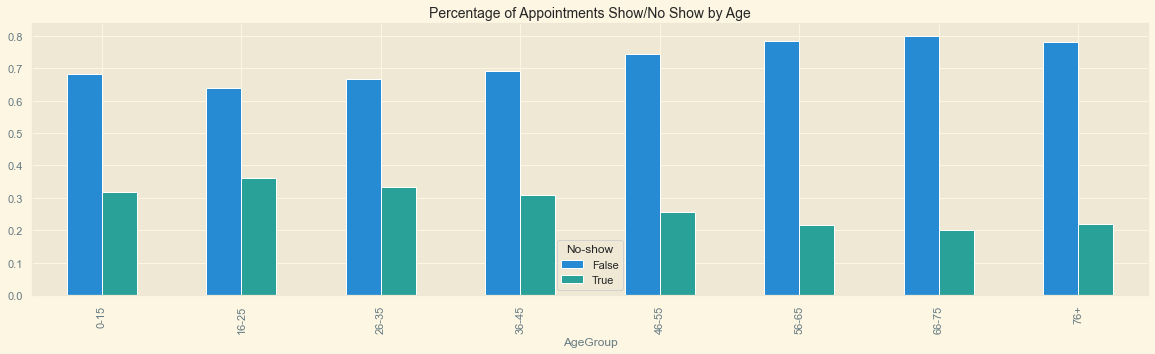

In [54]:
# appointment attendance by age
plt.style.use('Solarize_Light2')
g = df.groupby('AgeGroup')['No-show'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(20,5))
g.set_title("Percentage of Appointments Show/No Show by Age", fontsize=14);

The No-show rate of `0-15` looks similar to the `36-45`, perhaps because their parents are in that age group.  
Looking at patients over 16 years old, we can see that there is a linear relationship between age and the rate of 'no-show': The older, the lower the `no-show` rate.    
So the 5th null-hypothesis is not true.

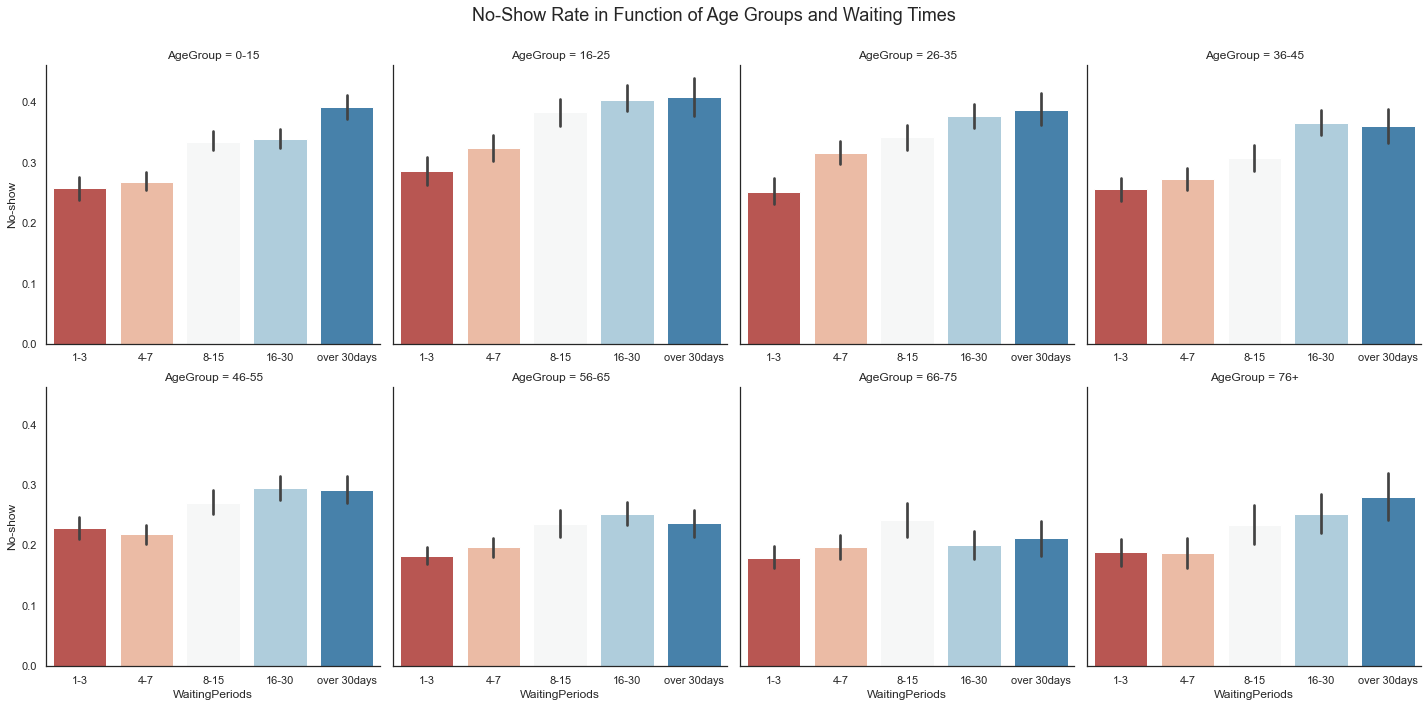

In [55]:
sns.set(context='notebook', style='white', rc={"figure.figsize": (10, 5)})
g = sns.catplot(data=df, y='No-show', col='AgeGroup', col_wrap=4, 
                x='WaitingPeriods', kind='bar', sharex=False, palette='RdBu')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('No-Show Rate in Function of Age Groups and Waiting Times', fontsize=18);

### Factor Gender

In [57]:
# table with the gender and the number of patient that missed or attended their appointment
gender_tbl = pd.DataFrame(df.groupby(['Gender','No-show'])['PatientId'].count()).reset_index()
gender_tbl

,Gender,No-show,PatientId
0,F,False,34395
1,F,True,13671
2,M,False,17041
3,M,True,6848


Text(0.5, 1.0, 'Percentage of Appointments Show/No Show by Gender')

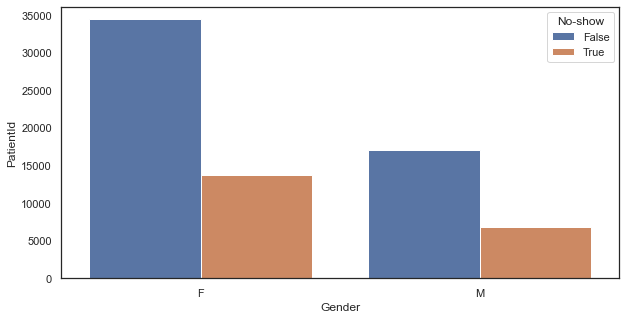

In [81]:
# appointment attendance by gender
sns.barplot(data=gender_tbl, y='PatientId', x='Gender',  hue='No-show', )
gender.set_title("Percentage of Appointments Show/No Show by Gender")

In [79]:
gender_tbl[gender_tbl['Gender']=='F']['PatientId'].sum()/gender_tbl[gender_tbl['Gender']=='M']['PatientId'].sum()

2.012055757880196

As we can see from above 'Female' patients have twice as much appointments as 'Male' patients. Regarding the no-show rate it is almost the same between both genders. However 14k no-shows in two months is a big number and something must be done about it.

In [84]:
df.groupby('Gender')['No-show'].value_counts(normalize=True)

Gender  No-show
F       False     0.72
        True      0.28
M       False     0.71
        True      0.29
Name: No-show, dtype: float64

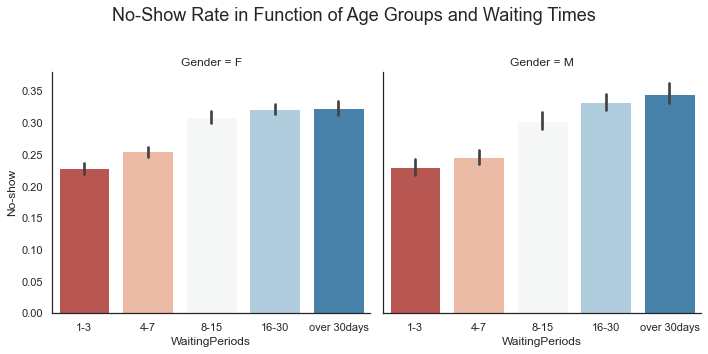

In [91]:
g = sns.catplot(data=df, y='No-show', col='Gender', 
                x='WaitingPeriods', kind='bar', sharex=False, palette='RdBu')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('No-Show Rate in Function of Gender and Waiting Times', fontsize=18);

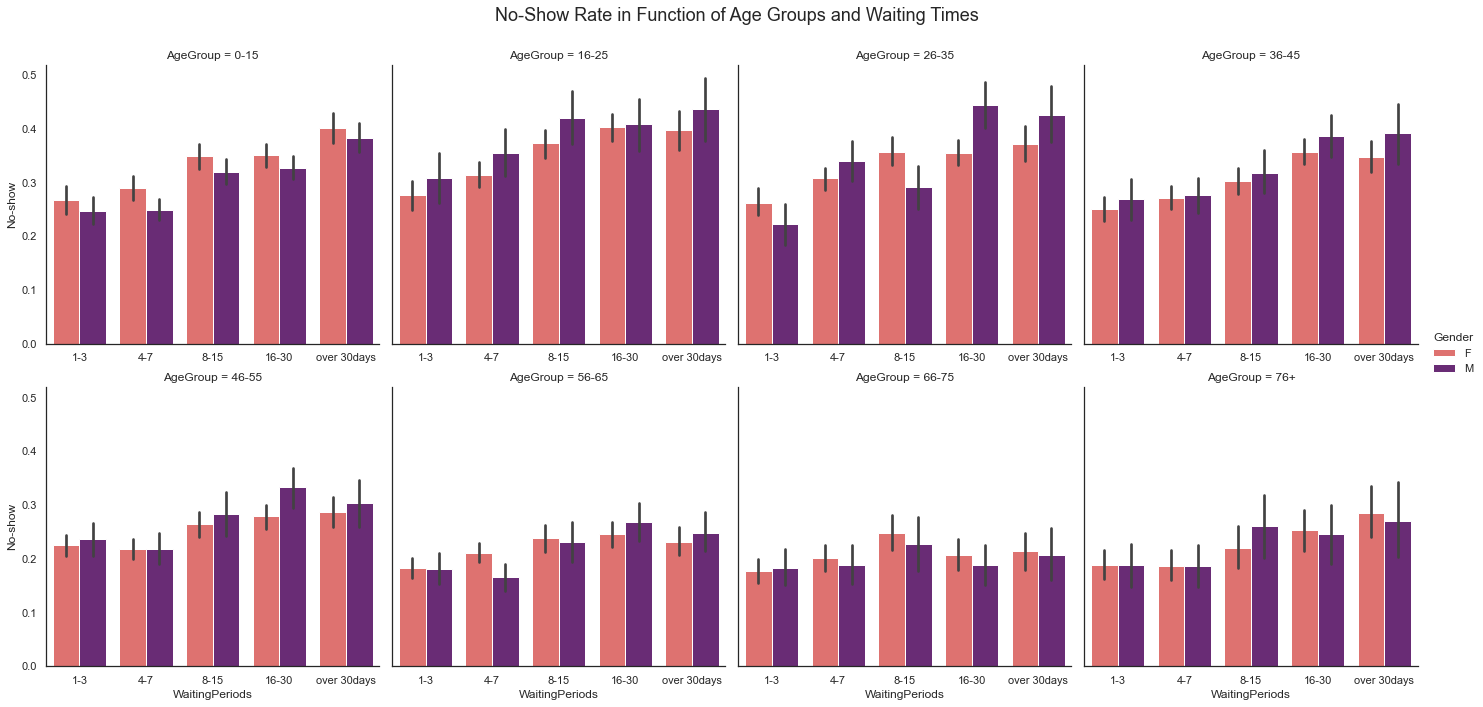

In [89]:
g = sns.catplot(data=df, y='No-show', col='AgeGroup', col_wrap=4, 
                x='WaitingPeriods', kind='bar', sharex=False, palette='magma_r', hue='Gender')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('No-Show Rate in Function of Age Groups and Waiting Times', fontsize=18);